In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

In [59]:
amino_acid_full_names = {
    'A': 'alanine', 'R': 'arginine', 'N': 'asparagine', 'D': 'aspartic_acid', 'C': 'cysteine', 
    'E': 'glutamic_acid', 'Q': 'glutamine', 'G': 'glycine', 'H': 'histidine', 'I': 'isoleucine', 
    'L': 'leucine', 'K': 'lysine', 'M': 'methionine', 'F': 'phenylalanine', 'P': 'proline',
    'S': 'serine', 'T': 'threonine', 'W': 'tryptophan', 'Y': 'tyrosine', 'V': 'valine'
}

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
#store images in cache to save performance
image_cache = {}

def load_AA_image(img_path):

    if img_path in image_cache:
        return image_cache[img_path]
    
    # Define transformation to do on image

    # Maybe not do it, if vgg is not the method
    transform = transforms.ToTensor()
    
    image = Image.open(img_path).convert('RGB')
    processed_image = transform(image).unsqueeze(0).to(device)
    
    image_cache[img_path] = processed_image
    
    return processed_image


torch.Size([20, 3, 400, 400])

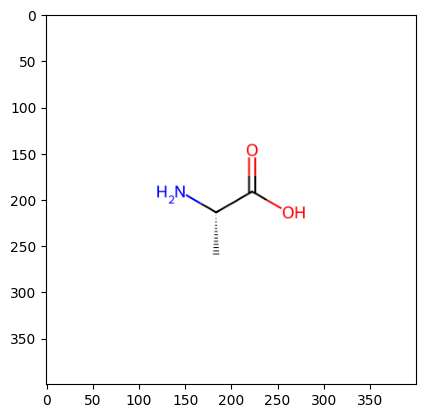

In [85]:
pixel_features = [] 

for letter, amino_acid in amino_acid_full_names.items():
    img_path = f'./2Dstruc/{amino_acid}.png'
    img = load_AA_image(img_path)
    pixel_features.append(img)

pixel_features = torch.vstack(pixel_features)
dataloader = DataLoader(pixel_features, batch_size=20)

# The transpose is necessary because the image is stored in a different way
plt.imshow(pixel_features[0].cpu().numpy().transpose(1, 2, 0))

pixel_features.shape

In [63]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(400*400*3, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 20)
        )

        self.decoder = nn.Sequential(
            nn.Linear(20, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 400*400*3),
            nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

# Note to self: If normalization is used, we will use 
# tanh as the activation function in the last layer

In [64]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # (N, 3, 400, 400) -> (N, 16, 200, 200)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (N, 16, 200, 200) -> (N, 32, 100, 100)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)  # (N, 32, 100, 100) -> (N, 64, 94, 94)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # (N, 64, 94, 94) -> (N, 32, 100, 100)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (N, 32, 100, 100) -> (N, 16, 200, 200)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # (N, 16, 200, 200) -> (N, 3, 400, 400)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = ConvAutoEncoder().to(device)


In [65]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [66]:
num_epochs = 5
outputs = []

for epoch in range(num_epochs):
    for img in dataloader:
        img = img.view(img.size(0), -1)  # Reshape with batch size preserved
        img = img.to(device)
        
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    outputs.append((epoch, img, output))

    torch.save(model.state_dict(), 'model_weights.pth')

Epoch [1/5], Loss: 0.2490
Epoch [2/5], Loss: 0.2713
Epoch [3/5], Loss: 0.2609
Epoch [4/5], Loss: 0.2429
Epoch [5/5], Loss: 0.2307


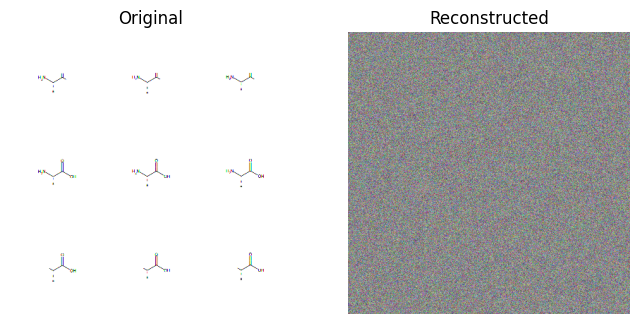

In [87]:
def plot_first_image(output):
    original_img = output[1][0].cpu().detach().numpy().reshape(400, 400, 3)
    reconstructed_img = output[2][0].cpu().detach().numpy().reshape(400, 400, 3)
    
    # Resize the reconstructed image to match the shape of the original image
    reconstructed_img = reconstructed_img[:original_img.shape[0], :original_img.shape[1], :]
    
    plt.figure(figsize=(8, 4))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis('off')
    
    # Plot reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_img)
    plt.title("Reconstructed")
    plt.axis('off')
    
    plt.show()

plot_first_image(outputs[-1])  # Plotting the first image from the last epoch

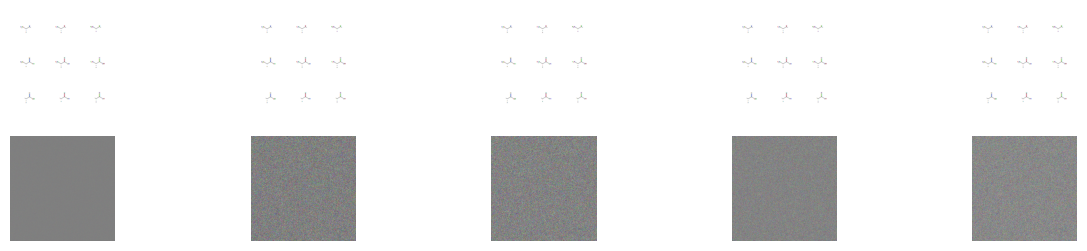

In [70]:
def plot_images(outputs, num_images=5):
    plt.figure(figsize=(15, 3))  # Adjust the figure size

    for i in range(num_images):
        imgs = outputs[i][1].cpu().detach().numpy()
        recon = outputs[i][2].cpu().detach().numpy()

        plt.subplot(2, num_images, i+1)
        plt.imshow(imgs[0].reshape(400, 400, 3))  # Original Image
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(recon[0].reshape(400, 400, 3))  # Reconstructed Image
        plt.axis('off')

    plt.show()

plot_images(outputs)
